# 08 Multi Likelihood Classification example 

_[Estimated time of execution: 3 min]_

This notebook shows how to train a multi-output dataset with different likelihoods using MOGPTK.

We create two artificial data sets: one of classification where `y ∈ {0,1}`, and one of a sinusoidal regression. We will use [`mogptk.gpr.MultiOutputLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.MultiOutputLikelihood) to use a different likelihood for each channel. Specifically, we'll use the [`mogptk.gpr.BernoulliLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.BernoulliLikelihood) for classification, and [`mogptk.gpr.StudentTLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.StudentTLikelihood) for regression.

In [1]:
import numpy as np
import torch
import mogptk
from sklearn.datasets import make_classification, make_regression

torch.manual_seed(1);

Create the artificial data set.

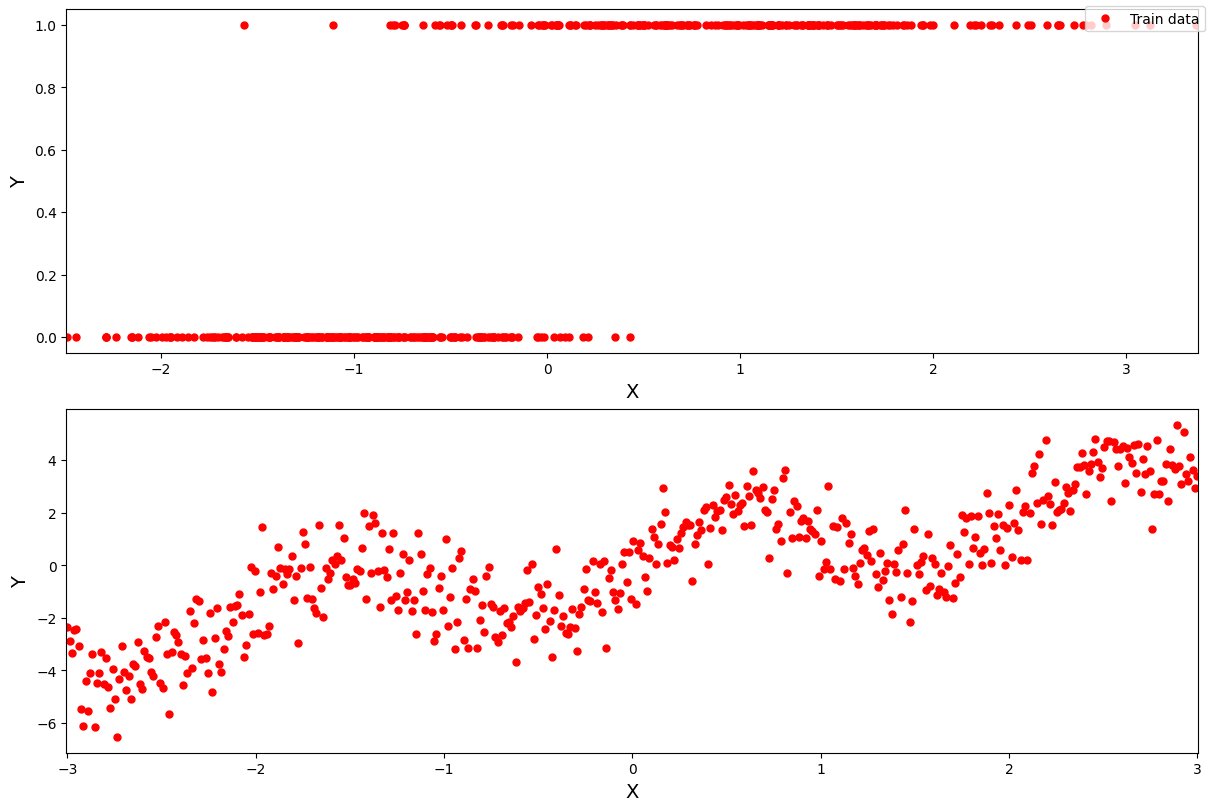

In [2]:
n = 500
X1, y1 = make_classification(n_samples=n, n_features=1,
                             n_informative=1, n_redundant=0,
                             n_clusters_per_class=1, random_state=1)
                             
X2 = np.linspace(-3.0, 3.0, n)
y2 = X2 + 1.5*np.sin(3.0*X2) + np.random.randn(n)

data = mogptk.DataSet(
    mogptk.Data(X1, y1),
    mogptk.Data(X2, y2),
)
data.plot();

Set up the model by using Hensman's Gaussian process inference, which allows us to use non-Gaussian likelihoods such as the [`mogptk.gpr.BernoulliLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.BernoulliLikelihood) and [`mogptk.gpr.StudentTLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.StudentTLikelihood) in this example. We will use the default squared exponential kernel for each channel and use the [`mogptk.gpr.multioutput.LinearModelOfCoregionalizationKernel`](https://games-uchile.github.io/mogptk/gpr/multioutput.html#mogptk.gpr.multioutput.LinearModelOfCoregionalizationKernel), also known as the LMC kernel, to learn the cross-channel features.

In [3]:
# Choose Bernoulli likelihood
likelihood = mogptk.gpr.MultiOutputLikelihood(
    mogptk.gpr.BernoulliLikelihood(),
    mogptk.gpr.StudentTLikelihood(),
)

# Choose inference
inference = mogptk.Hensman(likelihood=likelihood)

# Choose kernel
kernel = mogptk.gpr.LinearModelOfCoregionalizationKernel(
    mogptk.gpr.SquaredExponentialKernel(),
    mogptk.gpr.SquaredExponentialKernel(),
    output_dims=2,
)

# Set up model
model = mogptk.Model(data, kernel, inference=inference)

Training will be performed using the default Adam optimizer with a learning rate of `0.02` for a `500` iterations. We will additionally be measuring the error between the prediction and the target values using the mean absolute percentage error (MAPE), which is a relative error with respect to the target values.

Starting optimization using Adam
‣ Model: Hensman
  ‣ Kernel: LinearModelOfCoregionalizationKernel
  ‣ Likelihood: MultiOutputLikelihood['BernoulliLikelihood', 'StudentTLikelihood']
‣ Channels: 2
‣ Parameters: 501509
‣ Training points: 1000
‣ Iterations: 500
    0/500   0:00:01  loss=     2080.09  error=     74.7495
   58/500   0:00:10  loss=      1027.3  error=     128.188
  123/500   0:00:20  loss=     951.714  error=     120.509
  194/500   0:00:30  loss=     931.251  error=     107.798
  261/500   0:00:40  loss=     923.633  error=     104.203
  333/500   0:00:50  loss=     918.973  error=     102.589
  400/500   0:01:00  loss=     916.053  error=     101.754
  462/500   0:01:10  loss=     913.951  error=     101.293
  500/500   0:01:16  loss=     912.839  error=     101.109
Optimization finished in 1 minute 16 seconds


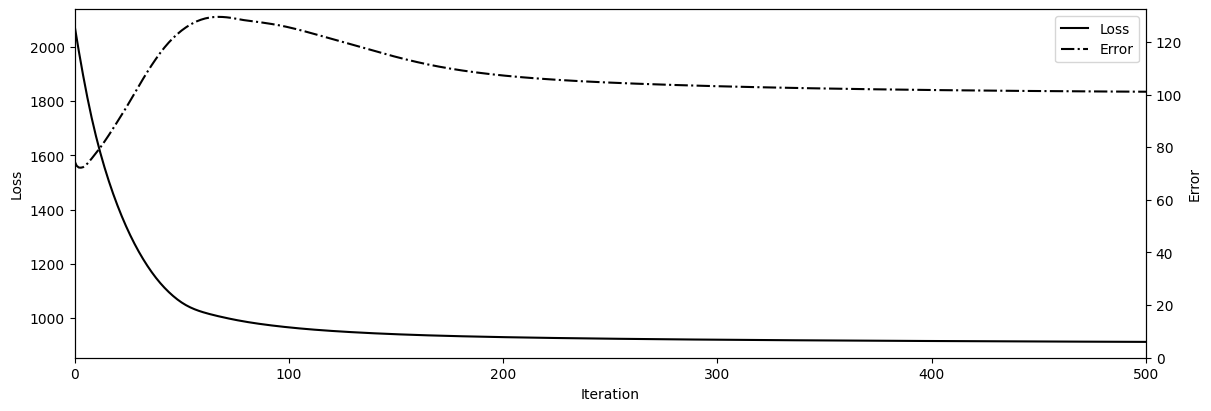

In [4]:
model.train(iters=500, verbose=True, error='mape', lr=0.02)
model.plot_losses();

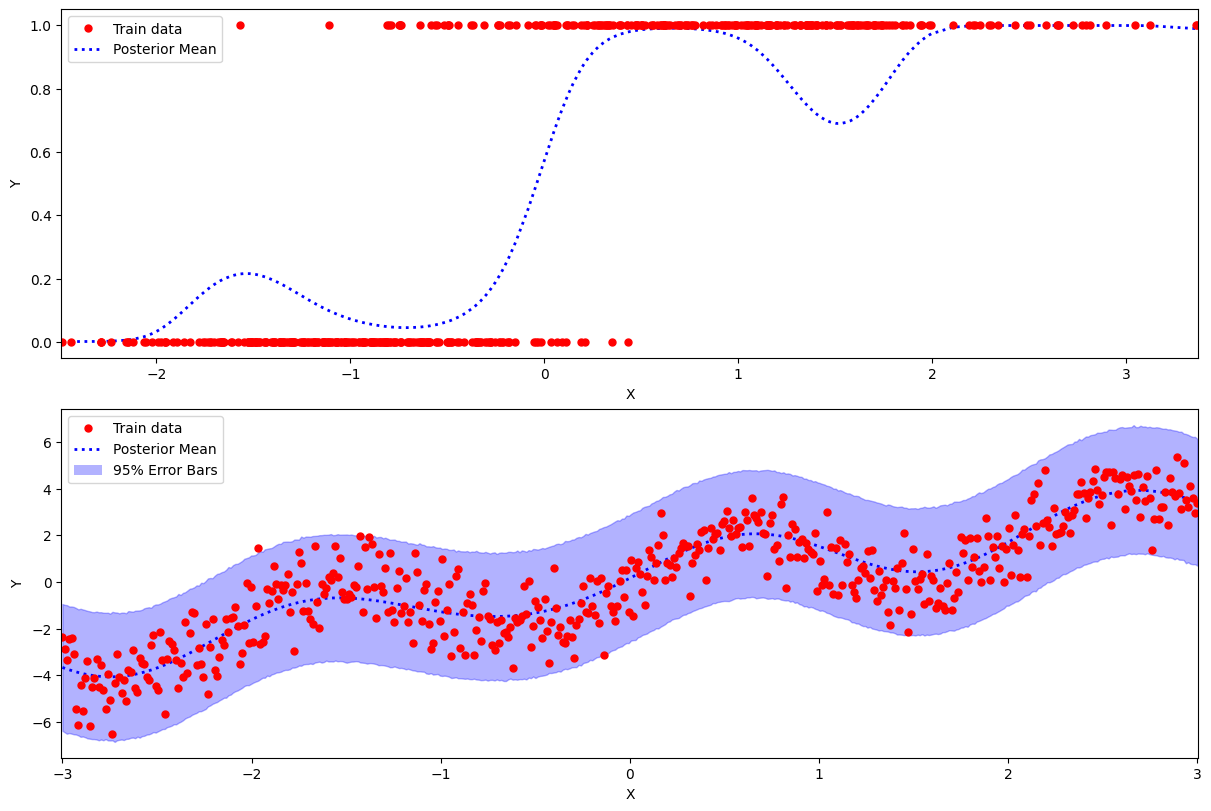

In [6]:
model.plot_prediction(n=100000);